In [1]:
# Import useful modules
import glob
import os
import os.path as op
import sys
import csv
import numpy as np
import pandas as pd
import time
import random as rand
import itertools
import copy
import utils

from os import chdir

from scipy import io as sio

import nibabel as nib
from nilearn.masking import compute_epi_mask
from nilearn.masking import apply_mask
from nilearn.input_data import MultiNiftiMasker

from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression

from nilearn import plotting
from nilearn.image import math_img, mean_img, threshold_img
from nilearn.plotting import plot_glass_brain
from nilearn.plotting import plot_anat
from nilearn.plotting import view_img
from nilearn.image import coord_transform
from nistats.design_matrix import make_first_level_design_matrix
from nistats import datasets
from nistats.reporting import plot_design_matrix


import neural_proba_filepath
from neural_proba_filepath import import_distrib_param
from neural_proba_filepath import distrib
from neural_proba_filepath import tuning_curve
from neural_proba_filepath import voxel
from neural_proba_filepath import experiment
from neural_proba_filepath import fmri

import matplotlib.pyplot as plt
from matplotlib import rc


%matplotlib inline

/home/tb258044/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/tb258044/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Experimental settings

In [3]:
## Compute X for each subject from ideal observer model output 

# Define the seed to reproduce results from random processes
rand.seed(4);

# INPUTS

# The parameters related to the scheme
scheme_array = ['gaussian_ppc', 'sigmoid_ppc', 'gaussian_dpc', 'sigmoid_dpc', 'rate']
n_schemes = len(scheme_array)

N_array = np.array([2, 3, 4, 5, 6, 7, 8, 10, 14, 20])

t_mu_gaussian_array = np.array([0.15, 0.12, 0.1, 8e-2, 7e-2, 6e-2, 5e-2, 4e-2, 3e-2, 2e-2])
t_conf_gaussian_array = np.array([0.25, 0.2, 0.15, 0.12, 0.10, 9e-2, 8e-2, 6e-2, 4e-2, 3e-2])

t_mu_sigmoid_array = np.sqrt(2*np.pi)/4*t_mu_gaussian_array
t_conf_sigmoid_array = np.sqrt(2*np.pi)/4*t_conf_gaussian_array

# Number of tuning curves that will be used for each scheme (results from simulation 1)
optimal_k_fit_N_array = np.array([3, 0, 2, 0, 1]).astype(int)

optimal_fit_N_array = np.zeros_like(optimal_k_fit_N_array).astype(float)
optimal_t_mu_array = np.zeros_like(optimal_k_fit_N_array).astype(float)
optimal_t_conf_array = np.zeros_like(optimal_k_fit_N_array).astype(float)
optimal_t_conf_array = np.zeros_like(optimal_k_fit_N_array).astype(float)

for k_fit_scheme in range(n_schemes-1):    # We exclude rate coding
    optimal_fit_N_array[k_fit_scheme] = N_array[optimal_k_fit_N_array[k_fit_scheme]]    # Optimal N
    # Now we fill values for optimal mu and t
    if k_fit_scheme % 2 == 0:    # Gaussian case
        t_mu_tmp = t_mu_gaussian_array[optimal_k_fit_N_array[k_fit_scheme]]
        t_conf_tmp = t_conf_gaussian_array[optimal_k_fit_N_array[k_fit_scheme]]
        optimal_t_mu_array[k_fit_scheme] = t_mu_tmp
        optimal_t_conf_array[k_fit_scheme] = t_conf_tmp
    else:  # Sigmoid case
        optimal_t_mu_array[k_fit_scheme] = t_mu_sigmoid_array[optimal_k_fit_N_array[k_fit_scheme]]
        optimal_t_conf_array[k_fit_scheme] = t_conf_sigmoid_array[optimal_k_fit_N_array[k_fit_scheme]]
# Assume there is one response curve in the rate coding case
optimal_fit_N_array[4] = 1 
        
# Lower and upper bounds of the encoded summary quantity (for tuning curves)
tc_lower_bound_mu = 0
tc_upper_bound_mu = 1
tc_lower_bound_conf = 1.1
# we define the upper bound to be a bit away from the highest uncertainty
tc_upper_bound_conf = 2.6

# Rate coding scaling parameters between probability and confidence neurons
mu_sd = 0.219    # Std of the signal of mu's
conf_sd = 0.284    # Std of the signal of conf's

# The number of possible N
n_N = len(N_array)

# The number of fractions tested (related to W)
n_fractions = 20

# Sparsity exponents
sparsity_exp_array = np.array([1, 2, 4, 8])
n_sparsity_exp = len(sparsity_exp_array)
between_population_sparsity_array = np.array([[0.5, 0.5], [0.25, 0.75], [0, 1], [0.75, 0.25], [1, 0]])

# The number of subjects
n_subjects = 1000

# Create the matrix with all the possibilities (mu or 1-mu encoded in each session) of size 16x4
directions = np.array(list(itertools.product([0,1], repeat=4)))
n_directions = len(directions)

# The number of sessions
n_sessions = 4

# Experimental options
n_stimuli = 380    # The number of stimuli per session
between_stimuli_duration = 1.3
min_break_time = 8
max_break_time = 12
min_n_local_regular_stimuli = 12
max_n_local_regular_stimuli = 18

# Transition proba or Bernoulli proba
distrib_type = 'transition' # transition or bernoulli

# SNR as defined by ||signal||²/(||signal||²+||noise||²)
snr = 0.1

In [4]:
def get_experiment_info(rootdir, k_subject):
    ''' Load the experiment information (onsets, durations, motions) and set conditions and frametimes 
    for design matrix creation''' 
    
    experiment_path = rootdir
    
    # Quantities to load and define 
    n_scans = [None for k_session in range(n_sessions)]
    onsets = [None for k_session in range(n_sessions)] 
    durations = [None for k_session in range(n_sessions)] 
    motion = [None for k_session in range(n_sessions)]  
    conditions = [None for k_session in range(n_sessions)] 
    frame_times = [None for k_session in range(n_sessions)] 

    # Import information about the slice timing 
    slice_timing_filepath = os.path.join(experiment_path,
                                "MRI_data/analyzed_data/",
                                "subj%02d/" % k_subject,
                                "preprocEPI/SliceTimingInfo.mat")
    slice_timing = sio.loadmat(slice_timing_filepath)
    t_r = slice_timing['TR'] # TR will be used for defining frame times 
    
    # Define SPM filepath 
    spm_filepath = os.path.join(experiment_path,
                                     "MRI_data/analyzed_data/",
                                     "subj%02d" % k_subject,
                                     "first_level_estimates/Model01_QualityCheck/SPM.mat") 
    
    for k_session in range(n_sessions):
        # Import the number of scans from MATLAB file 
        n_scans[k_session] = sio.loadmat(spm_filepath)['SPM']['nscan'][0][0][0][k_session]
        
        # Define frame times from no. scans and TR
        frame_times[k_session] = (np.arange(n_scans[k_session]) * t_r).flatten()
        
        ## Import the onsets and durations from MATLAB file 
        experiment_filepath = glob.glob(os.path.join(experiment_path,
                                                    "MRI_data/analyzed_data/",
                                                    "subj%02d/" % k_subject,
                                                    "MultiCond",
                                                    "Model1_QualityCheck_multicond*session%01d.mat" 
                                                     % int(k_session+1)))
        data_mat = sio.loadmat(experiment_filepath[0])
        # Load the onsets 
        onsets[k_session] = data_mat['onsets'][0][0].flatten()
        # Load the durations
        
        durations[k_session] =[(data_mat['durations'][0][0][0][0]) for i in range(onsets[k_session].size)]
    
        # Load motion information 
        motion_filepath = glob.glob(os.path.join(experiment_path,
                                                 "MRI_data/analyzed_data/",
                                                 "subj%02d" % k_subject,
                                                 "preprocEPI",
                                                 "rp_aepi_sess%01d*.txt" % int(k_session+1)))
        numconv = lambda x : str.replace(x.decode('utf-8'), 'D', 'E') # used for importing motion files
        motion[k_session] = np.loadtxt(motion_filepath[0], converters={
            0:numconv, 1:numconv, 2:numconv, 3:numconv, 4:numconv, 5:numconv})
        
        # Define conditions for design matrix creation
        conditions[k_session] = ['stim' for k in range(onsets[k_session].size)]
        
    return n_scans, frame_times, onsets, durations, motion, conditions

In [5]:
def compute_design_matrix(k_subject):
    # Import experimental settings 
    n_scans, frame_times, onsets, durations, motion, conditions = get_experiment_info(rootdir, k_subject)
    
    for k_session in range(n_sessions):
        ## Define events according to onsets, durations, conditions
        events = pd.DataFrame({'onset': onsets[k_session], 'duration': durations[k_session], 'trial_type': conditions[k_session]})

        # Concatenate the tuning curves and motion movements to include in the model regressors
        add_regs = motion[k_session]
        
        add_reg_names = []
        for k in range(motion[k_session].shape[1]):
            add_reg_names.append(f"mvt{k+1}")

        # Compute the design matrix in all cases (corresponds to mu in ppc and rate cases)
        design_matrix = make_first_level_design_matrix(frame_times[k_session], events, drift_model=None, 
                                                       period_cut=128, add_regs=add_regs, 
                                                       add_reg_names=add_reg_names, hrf_model='spm')
        design_matrix['session1'], design_matrix['session2'], design_matrix['session3'], design_matrix['session4'] = [0, 0, 0, 0]
        design_matrix[f"session{k_session+1}"] = 1 # add a column for the session (=1 for the current session)
        design_matrix = design_matrix.drop(columns="constant") # remove "constant" column
        if k_session == 0:
            design_mat_final = design_matrix
        else:
            # concatenate sessions vertically 
            design_mat_final = pd.concat([design_mat_final, design_matrix])

    design_mat_final.to_pickle('/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/ENCODAGE/design_matrices/subj'+str(k_subject).zfill(2)+'/dmtx_baseline.pkl')

In [6]:
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
rootdir = "/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/"
for sub in subjects:
    start = time.time()
    print(f'Creating baseline design matrix for subject {sub:02d}...')
    compute_design_matrix(sub)
    end = time.time()
    print(f'Subject {sub:02d} done in {end-start} seconds.')

Creating baseline design matrix for subject 01...


/home/tb258044/.local/lib/python3.7/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/tb258044/.local/lib/python3.7/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


Subject 01 done in 5.605247974395752 seconds.
Creating baseline design matrix for subject 02...
Subject 02 done in 5.964982986450195 seconds.
Creating baseline design matrix for subject 03...
Subject 03 done in 5.430360794067383 seconds.
Creating baseline design matrix for subject 04...
Subject 04 done in 5.725764751434326 seconds.
Creating baseline design matrix for subject 05...
Subject 05 done in 5.534982919692993 seconds.
Creating baseline design matrix for subject 06...
Subject 06 done in 5.1471264362335205 seconds.
Creating baseline design matrix for subject 07...
Subject 07 done in 5.485935211181641 seconds.
Creating baseline design matrix for subject 08...
Subject 08 done in 5.488487958908081 seconds.
Creating baseline design matrix for subject 09...
Subject 09 done in 5.467196702957153 seconds.
Creating baseline design matrix for subject 10...
Subject 10 done in 5.211613416671753 seconds.
Creating baseline design matrix for subject 11...
Subject 11 done in 5.1072351932525635 s

## Sanity checks

### Plot design matrices

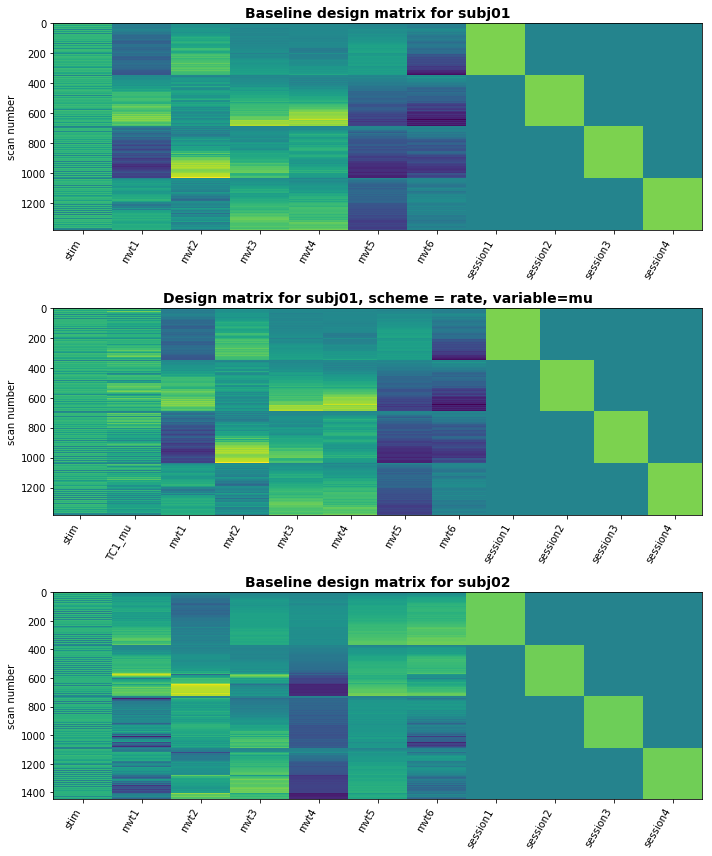

In [13]:
fig = plt.figure(figsize=[10,12])

ax1 = fig.add_subplot(311)
baseline_sub1 = pd.read_pickle("DesignMatrices/subj01/dmtx_baseline.pkl") # load matrix 
plot_design_matrix(baseline_sub1, ax=ax1)
plt.title('Baseline design matrix for subj01', fontweight='bold', fontsize=14)
plt.savefig('DesignMatrices/subj01/dmtx_baseline.pdf')

ax2 = fig.add_subplot(312)
design_mat_rate_mu = pd.read_pickle("DesignMatrices/subj01/dmtx_rate_mu_dir00.pkl")
plot_design_matrix(design_mat_rate_mu, ax=ax2)
plt.title('Design matrix for subj01, scheme = rate, variable=mu', fontweight='bold', fontsize=14)

ax3 = fig.add_subplot(313)
baseline_sub2 = pd.read_pickle("DesignMatrices/subj02/dmtx_baseline.pkl")
plot_design_matrix(baseline_sub2, ax=ax3)
plt.title('Baseline design matrix for subj02', fontweight='bold', fontsize=14)

plt.show()

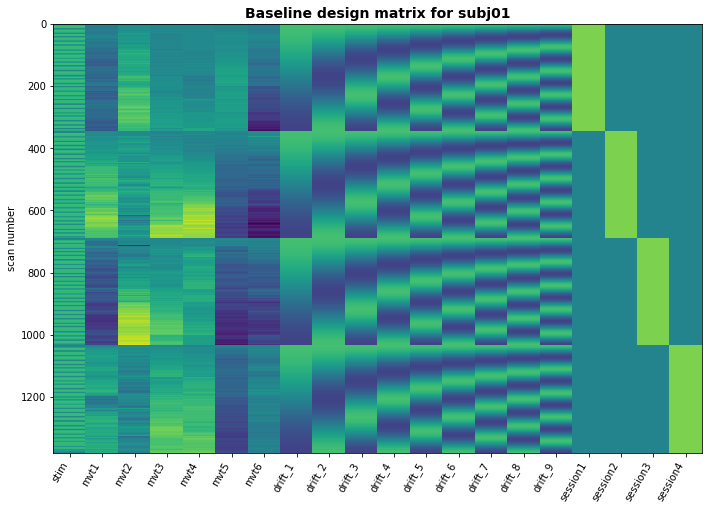

In [37]:
fig = plt.figure(figsize=[10,8])

ax1 = fig.add_subplot(111)
baseline_sub1 = pd.read_pickle("DesignMatrices/subj01/dmtx_baseline.pkl") # load matrix 
plot_design_matrix(baseline_sub1, ax=ax1)
plt.subplots_adjust(top=0.85)
plt.title('Baseline design matrix for subj01', fontweight='bold', fontsize=14)
plt.savefig('DesignMatrices/subj01/dmtx_baseline.jpg')